Import all required modules

In [25]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pyscf
from scipy.linalg import expm

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import HartreeFock

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import OptimizerResult
from qiskit_algorithms import VQE
from qiskit_algorithms import PhaseEstimation

from qiskit.primitives import StatevectorSampler, Sampler
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime import SamplerV2
from qiskit_ibm_runtime import QiskitRuntimeService


Declare global variables and define plotting functions

In [26]:
GRAPHS_DIR = 'graphs'

bond_lengths = [
    0.25,
    0.5,
    0.75,
    1.0,
    1.5,
    2.0,
    2.5,
    3.0,
    4.0,
    5.0,
    6.0
]

def makePlotFile(filename):
    output_file = os.path.join(GRAPHS_DIR, filename)  # Full file path

    # Create the directory if it doesn't exist
    if not os.path.exists(GRAPHS_DIR):
        os.makedirs(GRAPHS_DIR)

    return output_file

def plot_energy(points):
    print("Plotting Energy")

    # Unpack the x and y coordinates
    x_coords = [point[0] for point in points]
    y_coords = [point[1] for point in points]

    # Create the plot
    plt.scatter(x_coords, y_coords, color='blue', label='Points')  # Plot the points
    plt.plot(x_coords, y_coords, color='red', linestyle='--', label='Line')  # Connect the points with a line

    # Add labels and title
    plt.xlabel('R (a.u.)')
    plt.ylabel('E - 1/R (a.u.)')
    plt.title('Plot of Energy')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.savefig("graphs/energies.png")

    print("Plotting Alt. Energy")
    plt.clf()
    # Unpack the x and y coordinates
    x_coords = [point[0] for point in points]
    y_coords = [(point[1] + 1/point[0]) for point in points]

    # Create the plot
    plt.scatter(x_coords, y_coords, color='blue', label='Points')  # Plot the points
    plt.plot(x_coords, y_coords, color='red', linestyle='--', label='Line')  # Connect the points with a line

    # Add labels and title
    plt.xlabel('R (a.u.)')
    plt.ylabel('E (a.u.)')
    plt.title('Plot of Energy*')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.savefig("graphs/alt-energies.png")


def saveResults(resolution, results):
    print("Saving Results")

    energies = []

    for i, result in enumerate(results):
        counts = result.data.res.get_counts()
        fig = plot_histogram(counts)

        result_file = makePlotFile(f'qpe_hist_bl={bond_lengths[i]}.png')
        fig.savefig(result_file)

        # get the most frequent result
        max_key, max_value = max(counts.items(), key=lambda x: x[1])
        # Reverse the string with this circuit because the 
        # first is the least significative bit, etc.
        phi = int(max_key[::-1], 2) / ((2**resolution) - 1)

        energy = 2*np.pi * (phi - 1)
        energies.append((bond_lengths[i], energy))

        print(f'phi = {phi} => best approximation with 3 bits = {energy:.2f} Ha')

    plot_energy(energies)


Define Quantum Circuit construction functions

In [27]:
def QPE_circuit(bond_length):
    driver = PySCFDriver(atom=f'H .0 .0 .0; H .0 .0 {bond_length}', basis='sto3g')
    molecule = driver.run()
    hamiltonian = molecule.hamiltonian.second_q_op()
    mapper = ParityMapper(num_particles=molecule.num_particles)
    tapered_mapper = molecule.get_tapered_mapper(mapper)
    qubit_op = tapered_mapper.map(hamiltonian)

    state_in = HartreeFock(molecule.num_spatial_orbitals, molecule.num_particles, tapered_mapper)
    U = UnitaryGate(expm(1j*qubit_op.to_matrix()))

    return U, state_in

def opCircuit(pm, circuit):
    print("Optimising Circuit: " + circuit.name)
    isa_circuit = pm.run(circuit)
    isa_circuit.count_ops()

    return isa_circuit

def targetCircuit(num_result_bits, bond_length, backend):
    print(f"Creating Initial Circuit: bl={bond_length}")

    sampler = SamplerV2(mode=backend)

    qpe = PhaseEstimation(num_result_bits, sampler)

    U, state_in = QPE_circuit(bond_length)

    qr1 = QuantumRegister(num_result_bits, 'control')
    qr2 = QuantumRegister(1, 'target')
    cr = ClassicalRegister(num_result_bits, 'res')

    circuit = QuantumCircuit(qr1, qr2, cr, name=f'bl-{bond_length}')
    circuit.compose(qpe.construct_circuit(U, state_in), inplace=True)
    circuit.measure(qr1, cr)

    #output_file = makePlotFile(f'qpe_circ_bl={bond_length}.png')
    #makePlotFile(f'qpe_circ_bl={bond_length}.png')
    #isa_circuit.decompose().draw(output='mpl', filename=output_file)

    return circuit


Define functions to run quantum circuits on hardware.

In [28]:
def getBackend():
    print("Getting Backend")
    service = QiskitRuntimeService(channel="ibm_quantum")
    backend = service.backend(name="ibm_brisbane")
    print(backend.name)
    target = backend.target

    return backend, generate_preset_pass_manager(target=target, optimization_level=3)

def runCircuits(backend, circuits):
    print("Running circuits")

    sampler = SamplerV2(mode=backend)

    job = sampler.run(circuits)
    id = job.job_id()

    result = job.result()

    service = QiskitRuntimeService()
    job = service.job(id)

    return job.result()

Run the Experiment

In [29]:
print("Running Circuits on Hardware")

backend, pm = getBackend()

circuits = []

resolution = 4

for bond_length in bond_lengths:
    circuit = targetCircuit(resolution, bond_length, backend)

    isa_circuit = opCircuit(pm, circuit)

    circuits.append(isa_circuit)


Running Circuits on Hardware
Getting Backend
ibm_brisbane
Creating Initial Circuit: bl=0.25
Optimising Circuit: bl-0.25
Creating Initial Circuit: bl=0.5
Optimising Circuit: bl-0.5
Creating Initial Circuit: bl=0.75
Optimising Circuit: bl-0.75
Creating Initial Circuit: bl=1.0
Optimising Circuit: bl-1.0
Creating Initial Circuit: bl=1.5
Optimising Circuit: bl-1.5
Creating Initial Circuit: bl=2.0
Optimising Circuit: bl-2.0
Creating Initial Circuit: bl=2.5
Optimising Circuit: bl-2.5
Creating Initial Circuit: bl=3.0
Optimising Circuit: bl-3.0
Creating Initial Circuit: bl=4.0
Optimising Circuit: bl-4.0
Creating Initial Circuit: bl=5.0
Optimising Circuit: bl-5.0
Creating Initial Circuit: bl=6.0
Optimising Circuit: bl-6.0


In [30]:
# Run the circuits on Target Hardware
results = runCircuits(backend, circuits)

Running circuits


Saving Results
phi = 0.4 => best approximation with 3 bits = -3.77 Ha
phi = 0.2 => best approximation with 3 bits = -5.03 Ha
phi = 0.26666666666666666 => best approximation with 3 bits = -4.61 Ha
phi = 0.5333333333333333 => best approximation with 3 bits = -2.93 Ha
phi = 0.0 => best approximation with 3 bits = -6.28 Ha
phi = 0.13333333333333333 => best approximation with 3 bits = -5.45 Ha
phi = 0.3333333333333333 => best approximation with 3 bits = -4.19 Ha
phi = 0.7333333333333333 => best approximation with 3 bits = -1.68 Ha
phi = 0.6666666666666666 => best approximation with 3 bits = -2.09 Ha
phi = 0.4666666666666667 => best approximation with 3 bits = -3.35 Ha
phi = 0.7333333333333333 => best approximation with 3 bits = -1.68 Ha
Plotting Energy
Plotting Alt. Energy


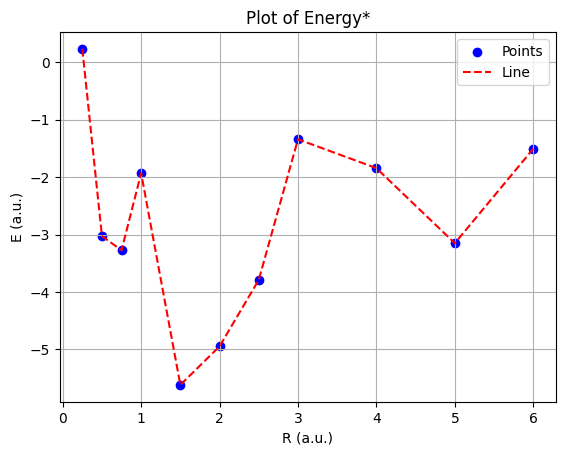

In [34]:
saveResults(resolution, results)